In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
from urllib.parse import urlparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from itertools import cycle

In [2]:
main = pd.read_csv("malicious_phish.csv")
main

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [3]:
import pandas as pd

# Define a list of file paths and corresponding types
file_paths = [
    ("FinalDataset/FinalDataset/URL/Benign_list_big_final.csv", "benign"),
    ("FinalDataset/FinalDataset/URL/DefacementSitesURLFiltered.csv", "defacement"),
    ("FinalDataset/FinalDataset/URL/Malware_dataset.csv", "malware"),
    ("FinalDataset/FinalDataset/URL/phishing_dataset.csv", "phishing"),
    ("FinalDataset/FinalDataset/URL/spam_dataset.csv", "spam")
]

# Initialize an empty list to store dataframes
dfs = []

# Iterate through the file paths and types
for file_path, url_type in file_paths:
    # Read the CSV file
    df = pd.read_csv(file_path, header=None)
    # Assign column names
    df.columns = ["url"]
    # Add a column for the URL type
    df["type"] = url_type
    # Append the dataframe to the list
    dfs.append(df)

dfs.append(main)
# Concatenate the list of dataframes into a single dataframe
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.drop_duplicates(inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# Display the merged dataframe
merged_df

,url,type
0,http://1337x.to/torrent/1048648/American-Snipe...,benign
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign
...,...,...
653041,xbox360.ign.com/objects/850/850402.html,phishing
653042,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
653043,www.gamespot.com/xbox360/action/deadspace/,phishing
653044,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


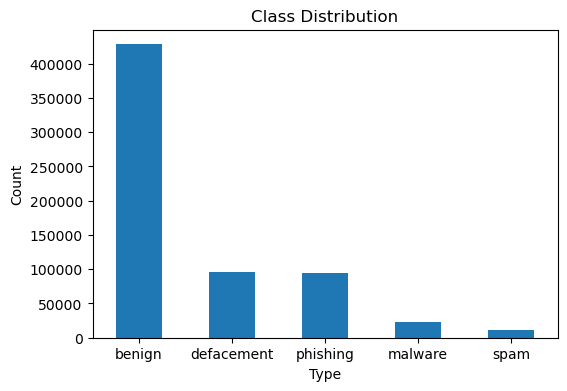

In [4]:
plt.figure(figsize=(6, 4))
merged_df["type"].value_counts().plot(kind="bar")
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=0)
plt.show()

In [5]:
def augment_url(url):
    augmentations = [
        lambda x: x + "?ref=" + str(random.randint(100, 999)), 
        lambda x: x + "/" + "help",
        lambda x: x + "/" + "support",
        lambda x: x + "/" + "faq",
        lambda x: x[:-1] if x.endswith("/") else x + "/",
        lambda x: x + "&utm_source=" + "newsletter",
    ]

    return [augment(url) for augment in augmentations]

In [6]:
class_counts = merged_df["type"].value_counts()
max_class_size = class_counts.max() 

print('Max Class Size:', max_class_size)
print('Class Counts:', class_counts)

Max Class Size: 428080
Class Counts: type
benign        428080
defacement     95308
phishing       94092
malware        23645
spam           11921
Name: count, dtype: int64


In [7]:
balanced_data = []
for category, count in class_counts.items():
    df_class = merged_df[merged_df["type"] == category]

    if count < max_class_size:
        extra_samples = max_class_size - count

        sampled_urls = random.choices(list(df_class["url"]), k=(extra_samples // 6) + 1)
        augmented_urls = [aug_url for url in sampled_urls for aug_url in augment_url(url)][:extra_samples]

        df_augmented = pd.DataFrame({"url": augmented_urls, "type": [category] * len(augmented_urls)})
        df_class = pd.concat([df_class, df_augmented])

    balanced_data.append(df_class)

df_balanced = pd.concat(balanced_data).sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
df_balanced.drop_duplicates(inplace=True)
df_balanced.dropna(inplace=True)

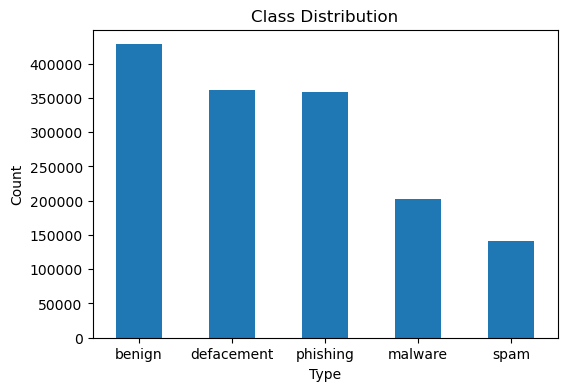

In [9]:
plt.figure(figsize=(6, 4))
df_balanced["type"].value_counts().plot(kind="bar")
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=0)
plt.show()

In [10]:
class_counts = df_balanced["type"].value_counts()

target_size = int(np.min(list(class_counts)))

balanced_data = []
for category, count in class_counts.items():
    df_class = df_balanced[df_balanced["type"] == category]

    if count > target_size:
        df_class = df_class.sample(n=target_size, random_state=42) 

    balanced_data.append(df_class)

df_balanced = pd.concat(balanced_data).sample(frac=1, random_state=42).reset_index(drop=True)

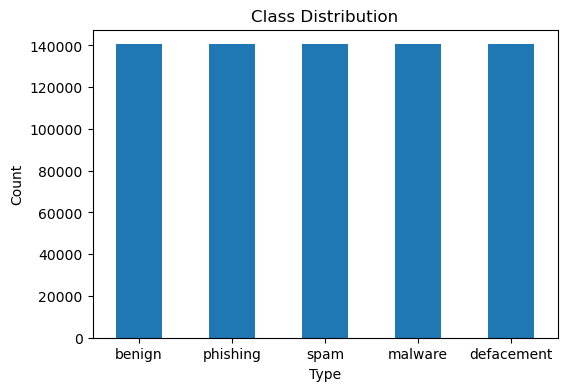

In [11]:
plt.figure(figsize=(6, 4))
df_balanced["type"].value_counts().plot(kind="bar")
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=0)
plt.show()

In [12]:
df_balanced

,url,type
0,facebook.com/people/Folco-Orlandini/1484697450,benign
1,searchenginewatch.com/article/2068086/NewHoo-Y...,phishing
2,http://amazon.co.uk/gp/offer-listing/B000EHTNS...,spam
3,publi-webs.com/modules/mod_mostread/login/remax/,benign
4,http://archive.salisburyjournal.co.uk/2000/7/2...,spam
...,...,...
702400,http://rateefa.com/hello-world/index.html?repl...,defacement
702401,bulletproofjobhunt.com,phishing
702402,economicexpert.com/a/Canadian:Navy.htm,benign
702403,http://archive.yorkpress.co.uk/2002/3/23/28908...,spam


# EDA

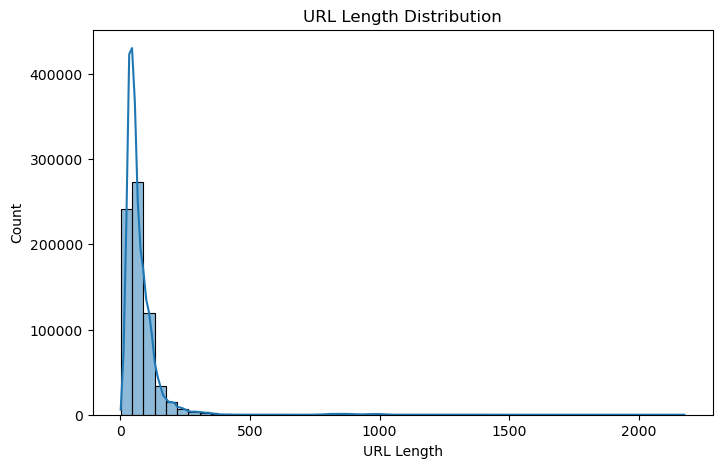

In [14]:
df_balanced["url_length"] = df_balanced["url"].apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(df_balanced["url_length"], bins=50, kde=True)
plt.title("URL Length Distribution")
plt.xlabel("URL Length")
plt.ylabel("Count")
plt.show()


C:\Users\abdul\AppData\Local\Temp\ipykernel_15808\2462813795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


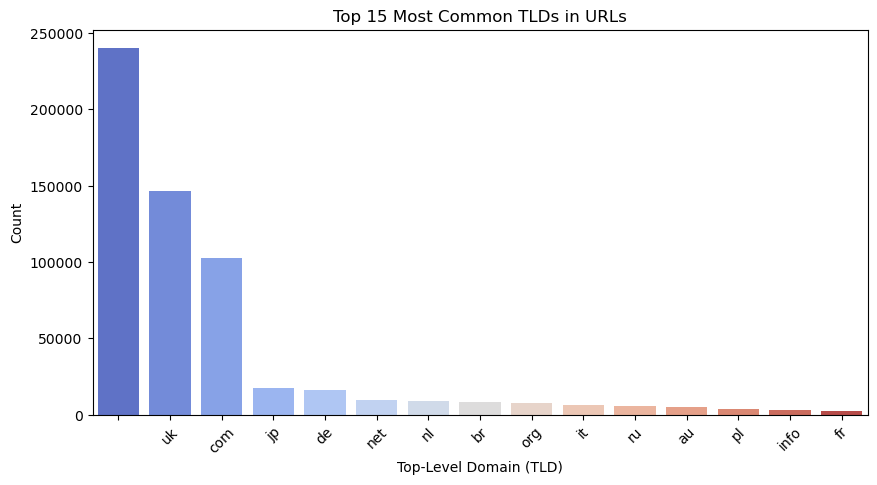

In [15]:
df_balanced["tld"] = df_balanced["url"].apply(lambda x: urlparse(x).netloc.split(".")[-1])

plt.figure(figsize=(10, 5))
sns.barplot(
    x=df_balanced["tld"].value_counts().head(15).index, 
    y=df_balanced["tld"].value_counts().head(15).values, 
    palette="coolwarm"
)
plt.title("Top 15 Most Common TLDs in URLs")
plt.xlabel("Top-Level Domain (TLD)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [21]:
df_balanced["domain"] = df_balanced["url"].apply(lambda x: urlparse(x).netloc)
df_balanced["path_length"] = df_balanced["url"].apply(lambda x: len(urlparse(x).path))

malicious_domains = df_balanced[df_balanced["type"] != "benign"]["domain"].value_counts().head(10)

In [22]:
malicious_domains

domain
                                  111092
mitsui-jyuku.mixh.jp               17104
adservers.co.uk                     7322
amber.ch.ic.ac.uk                   7001
archive.salisburyjournal.co.uk      6969
archive.thisisyork.co.uk            6814
astore.amazon.co.uk                 6805
amazon.co.uk                        6774
apbfiber.com                        6673
applerugs.co.uk                     6645
Name: count, dtype: int64

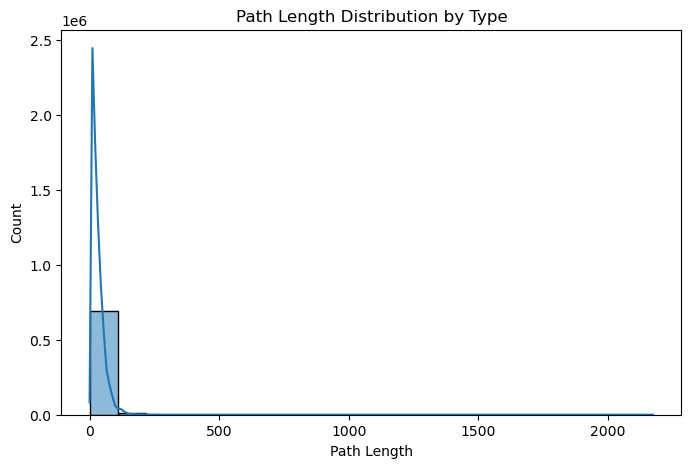

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(df_balanced["path_length"], bins=20, kde=True)
plt.title("Path Length Distribution by Type")
plt.xlabel("Path Length")
plt.ylabel("Count")
plt.show()

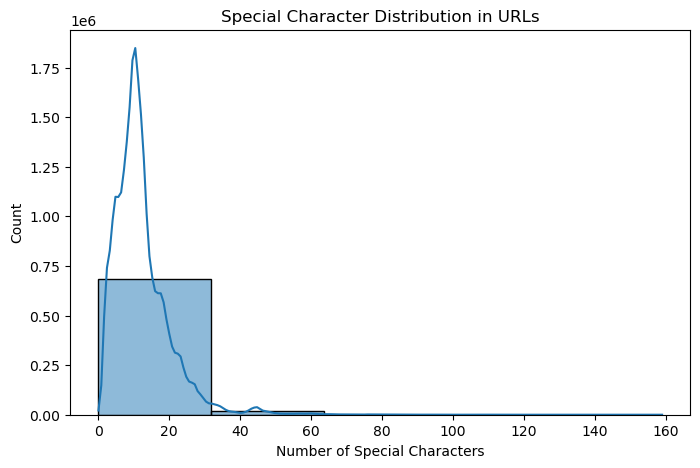

In [24]:
df_balanced["special_char_count"] = df_balanced["url"].apply(lambda x: sum(1 for char in x if not char.isalnum()))

plt.figure(figsize=(8, 5))
sns.histplot(df_balanced["special_char_count"], bins=5, kde=True)
plt.title("Special Character Distribution in URLs")
plt.xlabel("Number of Special Characters")
plt.ylabel("Count")
plt.show()

In [25]:
df_balanced

,url,type,url_length,tld,domain,path_length,special_char_count
0,facebook.com/people/Folco-Orlandini/1484697450,benign,46,,,46,5
1,searchenginewatch.com/article/2068086/NewHoo-Y...,phishing,70,,,70,9
2,http://amazon.co.uk/gp/offer-listing/B000EHTNS...,spam,209,uk,amazon.co.uk,63,43
3,publi-webs.com/modules/mod_mostread/login/remax/,benign,48,,,48,8
4,http://archive.salisburyjournal.co.uk/2000/7/2...,spam,81,uk,archive.salisburyjournal.co.uk,44,14
...,...,...,...,...,...,...,...
702400,http://rateefa.com/hello-world/index.html?repl...,defacement,62,com,rateefa.com,23,11
702401,bulletproofjobhunt.com,phishing,22,,,22,1
702402,economicexpert.com/a/Canadian:Navy.htm,benign,38,,,38,5
702403,http://archive.yorkpress.co.uk/2002/3/23/28908...,spam,60,uk,archive.yorkpress.co.uk,22,13


# Feature Extraction/Engineering

In [27]:
df_balanced["num_digits"] = df_balanced["url"].apply(lambda x: sum(c.isdigit() for c in x))
df_balanced["num_subdomains"] = df_balanced["domain"].apply(lambda x: x.count("."))

In [28]:
df_balanced.drop(columns=["tld", "domain"], inplace=True)

In [29]:
df_balanced

,url,type,url_length,path_length,special_char_count,num_digits,num_subdomains
0,facebook.com/people/Folco-Orlandini/1484697450,benign,46,46,5,10,0
1,searchenginewatch.com/article/2068086/NewHoo-Y...,phishing,70,70,9,7,0
2,http://amazon.co.uk/gp/offer-listing/B000EHTNS...,spam,209,63,43,60,2
3,publi-webs.com/modules/mod_mostread/login/remax/,benign,48,48,8,0,0
4,http://archive.salisburyjournal.co.uk/2000/7/2...,spam,81,44,14,13,3
...,...,...,...,...,...,...,...
702400,http://rateefa.com/hello-world/index.html?repl...,defacement,62,23,11,1,1
702401,bulletproofjobhunt.com,phishing,22,22,1,0,0
702402,economicexpert.com/a/Canadian:Navy.htm,benign,38,38,5,0,0
702403,http://archive.yorkpress.co.uk/2002/3/23/28908...,spam,60,22,13,16,3


In [35]:
tfidf = TfidfVectorizer(analyzer="char", max_features=2500)
tfidf_features = tfidf.fit_transform(df_balanced["url"])

In [36]:
tfidf_features.shape

(702405, 271)

# Model Training

In [56]:
label_encoder = LabelEncoder()
df_balanced["type"] = label_encoder.fit_transform(df_balanced["type"]) 
y = df_balanced["type"]
class_names = label_encoder.classes_
n_classes = len(class_names)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, y, test_size=0.2, random_state=42)

In [62]:
clf = RandomForestClassifier(n_estimators=5, verbose=10, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=42, verbose=10)

In [63]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test) 

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.2s finished


In [64]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9128


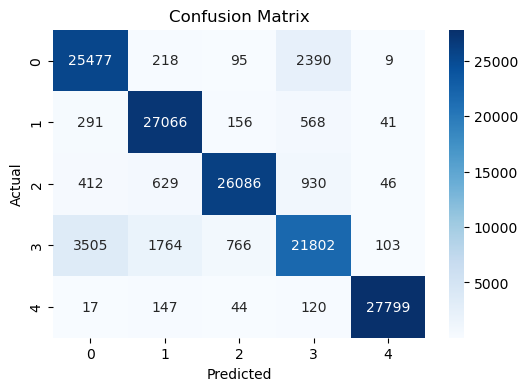

In [65]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

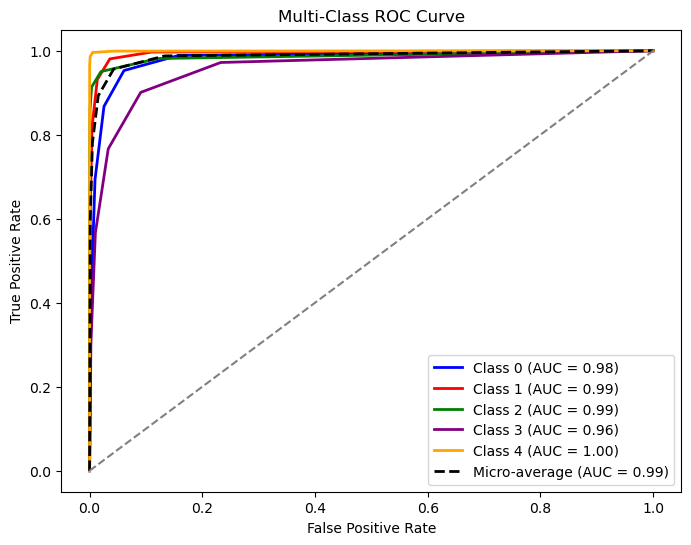

In [66]:
y_test_bin = label_binarize(y_test, classes=range(n_classes))  # Convert to binary labels

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green", "purple", "orange", "brown", "pink", "gray", "cyan", "magenta"])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot(fpr["micro"], tpr["micro"], color="black", linestyle="--", lw=2, label=f"Micro-average (AUC = {roc_auc['micro']:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.show()